In [55]:
%%capture
!pip install nlpaug
!pip install nltk
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install keras
!pip install -U scikit-learn
!pip install -U imbalanced-learn

In [124]:
from google.colab import files
uploaded = files.upload()

Saving eda.txt to eda.txt
Saving data_eda.txt to data_eda.txt


In [110]:
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import pandas as pd
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
import re
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_style('darkgrid')

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.combine import SMOTETomek 
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras import layers
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english')) 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [58]:
data = pd.read_csv('Data/train.csv')
data = data.drop(columns=['id'])
data.head()

,label,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation


In [59]:
data.shape

(31962, 2)

In [60]:
def lowercase(text):
    text = text.lower()
    return text

def remove_punction(text):
    text = re.sub(r'[^a-z0-9 ]+', '', text)
    return text
    
def only_letters(text):
    text = re.sub(r'[^a-z ]', '', text)
    return text

def remove_spam(text):
    text = re.sub(r'\&\S+\;', '', text)
    return text
    
def format_text(text):
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text

def remove_user(text):
    text = re.sub(r'\@[^\s]+', '', text)
    return text

def remove_hashtag(text):
    text = re.sub(r'\#[^\s]+', '', text)
    return text

def remove_link(text):
    text = re.sub(r'https?[^\s]+', '', text)
    text = re.sub(r'www\.[^\s]+', '', text)
    text = re.sub(r'www\s?[^\s]+\s?com', '', text)
    return text

def remove_stopwords(text):
    words = text.split(' ')
    no_stopwords = [word for word in words if word not in stop_words]
    return ' '.join(no_stopwords)

def preprocessing(data):
    data = pd.Series(data)
    data = data.apply(str)
    data = data.apply(lowercase)
    data = data.apply(remove_user)
    data = data.apply(remove_link)
    data = data.apply(remove_spam)
    data = data.apply(remove_punction)
    data = data.apply(only_letters)
    data = data.apply(remove_stopwords)
    data = data.apply(format_text)
    return data

In [61]:
data.shape

(31962, 2)

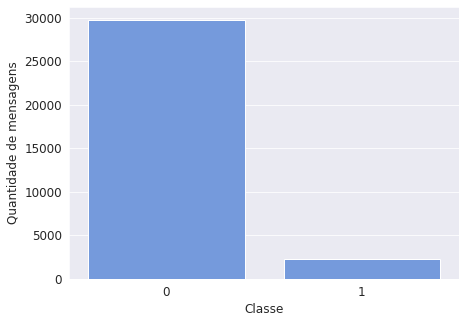

In [62]:
plt.figure(figsize=(7, 5))
sns.countplot(data=data, x='label', color='cornflowerblue')
plt.xlabel('Classe', fontsize=12)
plt.ylabel('Quantidade de mensagens', fontsize=12)
plt.tick_params(labelsize=12)
plt.savefig('Images/distribuição_dados.png')

In [63]:
data['label'].value_counts()

0    29720
1     2242
Name: label, dtype: int64

In [64]:
%%time
data['cleaned_tweet'] = data['tweet'].apply(lowercase)
data.head()

CPU times: user 31.4 ms, sys: 3.04 ms, total: 34.4 ms
Wall time: 36.5 ms


## Text Augmentation

In [65]:
def text_augmentation(data, model):
    
    model = model.lower()
    
    if model == 'randomoversampler' or model == 'random over sampler':
        #over sampling
        ros = RandomOverSampler(random_state=42, sampling_strategy='minority')
        X_resampled, y_resampled = ros.fit_resample(data[['cleaned_tweet']], data['label'])
        data_resampled = pd.concat([X_resampled, y_resampled], axis=1)
        return data_resampled
    elif model == 'smote':
        smote = SMOTE(random_state=42, sampling_strategy='minority')
        X_resampled, y_resampled = smote.fit_resample(data[['cleaned_tweet']], data['label'])
        data_resampled = pd.concat([X_resampled, y_resampled], axis=1)
        return data_resampled
    elif model == 'smotetomek' or model == 'smote tomek':
        tomek = SMOTETomek(random_state=42)
        X_resampled, y_resampled = tomek.fit_resample(data[['cleaned_tweet']], data['label'])
        data_resampled = pd.concat([X_resampled, y_resampled], axis=1)
        return data_resampled
    elif model == 'nlpaug':
        aug_texts = []
        minority_data = data[data['label'] == 1]
        aug = naw.SynonymAug(aug_src='wordnet')
        augmented_texts = aug.augment(minority_data['cleaned_tweet'].tolist(), n=15)
        
        for text in augmented_texts:
            aug_texts.append(text)
        
        temp = pd.DataFrame({
            'tweet': aug_texts
        })
        
        temp['label'] = 1
        
        data = pd.concat([data, temp], axis=0)
        data = data.reset_index()
        data = data.drop(columns=['index'])
        del temp, minority_data
        return data

## Processing

In [66]:
def processing(X_train, X_test):
    
    tokenizer = Tokenizer(num_words=5000)
    tokenizer.fit_on_texts(X_train)

    X_train = tokenizer.texts_to_sequences(X_train)
    X_test = tokenizer.texts_to_sequences(X_test)

    vocab_size = len(tokenizer.word_index) + 1

    maxlen = 100

    X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
    X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
    
    return X_train, X_test, vocab_size, tokenizer

## Creating the model

In [67]:
def create_model(vocab_size):
    model = Sequential()
    model.add(layers.Embedding(input_dim=vocab_size, 
                               output_dim=50, 
                               input_length=100))
    model.add(layers.Conv1D(64, 5, activation='relu', padding='same'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

## Plot

In [68]:
def plot_model(model, data_augmentation):
    loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
    print("Training Accuracy: {:.4f}".format(accuracy))
    loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
    print("Testing Accuracy:  {:.4f}".format(accuracy))

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])

    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc = 'upper left')
    plt.savefig('Images/accuracy_'+data_augmentation+'.png')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])

    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc = 'upper left')
    plt.savefig('Images/loss_'+data_augmentation+'.png')
    plt.show()

## Submission

In [69]:
def submission(model, tokenizer, name):
    test = pd.read_csv('Data/test.csv')
    test_id = test['id']
    test = test.drop(columns=['id'])
    test['tweet'] = test['tweet'].apply(lowercase)
    
    test = tokenizer.texts_to_sequences(test['tweet'])
    test = pad_sequences(test, padding='post', maxlen=100)
    
    prediction = (model.predict(test) > 0.5).astype("int32")
    predict = [int(p) for p in prediction]
    
    submission = pd.DataFrame({
        'id': test_id,
        'label': predict
    })

    submission.to_csv(name, index=False)

### Random Over Sampler

In [70]:
data = pd.read_csv('Data/train.csv')
data = data.drop(columns=['id'])

In [71]:
%%time
data['cleaned_tweet'] = data['tweet'].apply(lowercase)
data.head()

CPU times: user 22.8 ms, sys: 3.02 ms, total: 25.8 ms
Wall time: 25.3 ms


In [72]:
data_resampled = text_augmentation(data, 'randomoversampler')
data.head()

,label,tweet,cleaned_tweet
0,0,@user when a father is dysfunctional and is s...,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty,bihday your majesty
3,0,#model i love u take with u all the time in ...,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation,factsguide: society now #motivation


In [73]:
data_resampled.shape

(59440, 2)

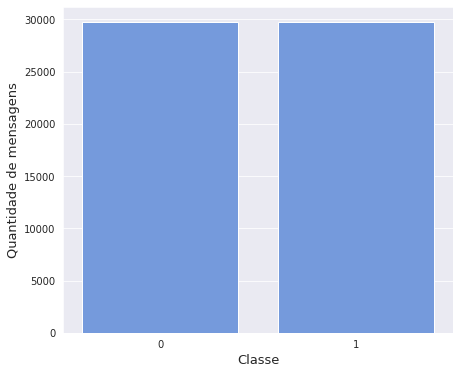

In [74]:
plt.figure(figsize=(7, 6))
sns.countplot(data=data_resampled, x='label', color='cornflowerblue')
plt.xlabel('Classe', fontsize=13)
plt.ylabel('Quantidade de mensagens', fontsize=13)
plt.savefig('Images/nova_distribuição_dados_ros.png')

In [75]:
data_resampled['label'].value_counts()

1    29720
0    29720
Name: label, dtype: int64

In [76]:
X_train, X_test, y_train, y_test = train_test_split(data_resampled['cleaned_tweet'],
                                                    data_resampled['label'],
                                                    test_size=0.2,
                                                    random_state=23)

In [77]:
X_train, X_test, max_len, tokenizer = processing(X_train, X_test)

In [78]:
model = create_model(max_len)
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 50)           1996400   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 100, 64)           16064     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 2,012,529
Trainable params: 2,012,529
Non-trainable params: 0
_________________________________________________________________


In [79]:
%%time
history = model.fit(X_train, y_train,
                    epochs=5,
                    validation_data=(X_test, y_test),
                    batch_size=10)

Epoch 1/5
4756/4756 [==============================] - 118s 25ms/step - loss: 0.2471 - accuracy: 0.8908 - val_loss: 0.0379 - val_accuracy: 0.9868
Epoch 2/5
4756/4756 [==============================] - 113s 24ms/step - loss: 0.0169 - accuracy: 0.9952 - val_loss: 0.0275 - val_accuracy: 0.9915
Epoch 3/5
4756/4756 [==============================] - 117s 25ms/step - loss: 0.0035 - accuracy: 0.9990 - val_loss: 0.0120 - val_accuracy: 0.9968
Epoch 4/5
4756/4756 [==============================] - 113s 24ms/step - loss: 0.0014 - accuracy: 0.9997 - val_loss: 0.0200 - val_accuracy: 0.9951
Epoch 5/5
4756/4756 [==============================] - 117s 25ms/step - loss: 5.7756e-04 - accuracy: 0.9999 - val_loss: 0.0290 - val_accuracy: 0.9930
CPU times: user 15min 4s, sys: 55.7 s, total: 16min
Wall time: 10min 22s


Training Accuracy: 0.9999
Testing Accuracy:  0.9930


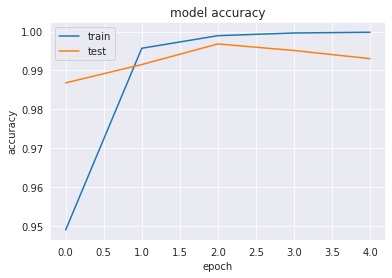

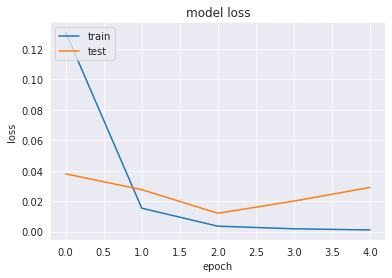

In [80]:
plot_model(model, data_augmentation='ros')

In [81]:
submission(model, tokenizer, 'Submissions/submission_ros.csv')

### SMOTE

In [82]:
data = pd.read_csv('Data/train.csv')
data = data.drop(columns=['id'])

In [83]:
%%time
data['cleaned_tweet'] = data['tweet'].apply(lowercase)
data.head()

CPU times: user 23.9 ms, sys: 1.01 ms, total: 24.9 ms
Wall time: 25 ms


In [84]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(data)

data['cleaned_tweet'] = tokenizer.texts_to_sequences(data['cleaned_tweet'])
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

data['cleaned_tweet'] = pad_sequences(data['cleaned_tweet'], padding='post', maxlen=maxlen)

In [85]:
data_resampled = text_augmentation(data, 'smote')

In [86]:
data_resampled.shape

(59440, 2)

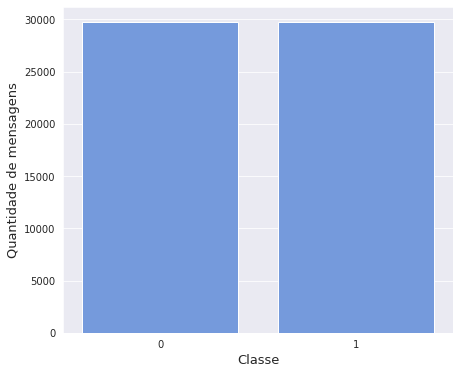

In [87]:
plt.figure(figsize=(7, 6))
sns.countplot(data=data_resampled, x='label', color='cornflowerblue')
plt.xlabel('Classe', fontsize=13)
plt.ylabel('Quantidade de mensagens', fontsize=13)
plt.savefig('Images/nova_distribuição_dados_smote.png')

In [88]:
data_resampled['label'].value_counts()

1    29720
0    29720
Name: label, dtype: int64

In [89]:
X_train, X_test, y_train, y_test = train_test_split(data_resampled['cleaned_tweet'], 
                                                    data_resampled['label'], 
                                                    test_size=0.2,
                                                    random_state=23)

In [90]:
model = create_model(max_len)
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 50)           1996400   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 100, 64)           16064     
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 2,012,529
Trainable params: 2,012,529
Non-trainable params: 0
_________________________________________________________________


In [91]:
%%time
history = model.fit(X_train, y_train,
                    epochs=5,
                    validation_data=(X_test, y_test),
                    batch_size=10)

Epoch 1/5
4756/4756 [==============================] - 97s 20ms/step - loss: 0.6929 - accuracy: 0.5010 - val_loss: 0.6935 - val_accuracy: 0.4997
Epoch 2/5
4756/4756 [==============================] - 94s 20ms/step - loss: 0.6927 - accuracy: 0.5046 - val_loss: 0.6931 - val_accuracy: 0.5020
Epoch 3/5
4756/4756 [==============================] - 96s 20ms/step - loss: 0.6928 - accuracy: 0.4965 - val_loss: 0.6932 - val_accuracy: 0.4997
Epoch 4/5
4756/4756 [==============================] - 98s 21ms/step - loss: 0.6929 - accuracy: 0.4989 - val_loss: 0.6942 - val_accuracy: 0.5020
Epoch 5/5
4756/4756 [==============================] - 97s 20ms/step - loss: 0.6927 - accuracy: 0.5024 - val_loss: 0.6936 - val_accuracy: 0.4997
CPU times: user 12min 37s, sys: 35.2 s, total: 13min 12s
Wall time: 8min 2s


Training Accuracy: 0.5029
Testing Accuracy:  0.4997


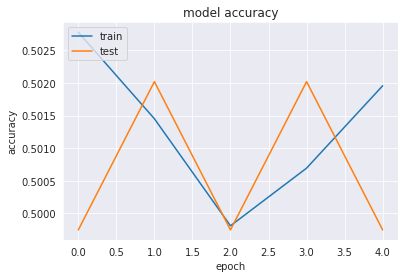

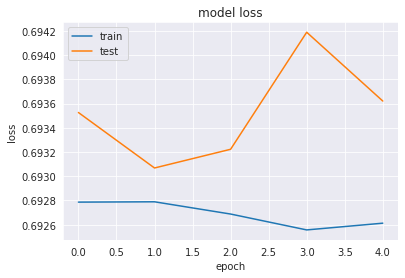

In [92]:
plot_model(model, data_augmentation='smote')

In [93]:
submission(model, tokenizer, 'Submissions/submission_smote.csv')

### SMOTETomek

In [94]:
data = pd.read_csv('Data/train.csv')
data = data.drop(columns=['id'])

In [95]:
%%time
data['cleaned_tweet'] = data['tweet'].apply(lowercase)
data.head()

CPU times: user 23.2 ms, sys: 40 µs, total: 23.2 ms
Wall time: 23.8 ms


In [96]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(data['cleaned_tweet'])

data['cleaned_tweet'] = tokenizer.texts_to_sequences(data['cleaned_tweet'])
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

data['cleaned_tweet'] = pad_sequences(data['cleaned_tweet'], padding='post', maxlen=maxlen)

In [97]:
data_resampled = text_augmentation(data, 'smotetomek')

In [98]:
data_resampled.shape

(59338, 2)

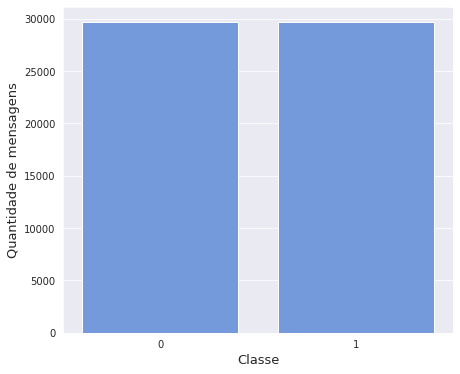

In [99]:
plt.figure(figsize=(7, 6))
sns.countplot(data=data_resampled, x='label', color='cornflowerblue')
plt.xlabel('Classe', fontsize=13)
plt.ylabel('Quantidade de mensagens', fontsize=13)
plt.savefig('Images/nova_distribuição_dados_smotetomek.png')

In [100]:
data_resampled['label'].value_counts()

1    29669
0    29669
Name: label, dtype: int64

In [101]:
X_train, X_test, y_train, y_test = train_test_split(data_resampled['cleaned_tweet'],
                                                    data_resampled['label'],
                                                    test_size=0.2,
                                                    random_state=23)

In [102]:
model = create_model(max_len)
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 50)           1996400   
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 100, 64)           16064     
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 2,012,529
Trainable params: 2,012,529
Non-trainable params: 0
_________________________________________________________________


In [103]:
%%time
history = model.fit(X_train, y_train,
                    epochs=5,
                    validation_data=(X_test, y_test),
                    batch_size=10)

Epoch 1/5
4747/4747 [==============================] - 92s 19ms/step - loss: 0.5766 - accuracy: 0.6957 - val_loss: 0.5307 - val_accuracy: 0.7251
Epoch 2/5
4747/4747 [==============================] - 93s 20ms/step - loss: 0.5008 - accuracy: 0.7523 - val_loss: 0.5299 - val_accuracy: 0.7258
Epoch 3/5
4747/4747 [==============================] - 90s 19ms/step - loss: 0.4868 - accuracy: 0.7583 - val_loss: 0.5345 - val_accuracy: 0.7274
Epoch 4/5
4747/4747 [==============================] - 90s 19ms/step - loss: 0.4848 - accuracy: 0.7568 - val_loss: 0.5326 - val_accuracy: 0.7281
Epoch 5/5
4747/4747 [==============================] - 89s 19ms/step - loss: 0.4859 - accuracy: 0.7534 - val_loss: 0.5402 - val_accuracy: 0.7300
CPU times: user 11min 47s, sys: 32.4 s, total: 12min 19s
Wall time: 7min 34s


Training Accuracy: 0.7581
Testing Accuracy:  0.7300


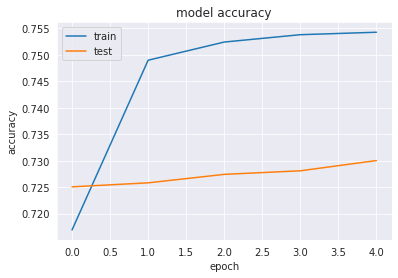

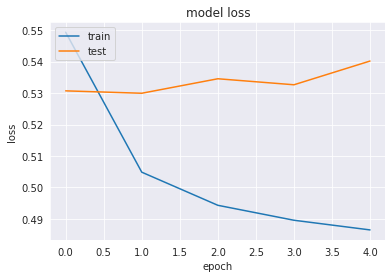

In [104]:
plot_model(model, data_augmentation='smotetomek')

In [105]:
submission(model, tokenizer, 'Submissions/submission_smotetomek.csv')

### NLPAUG

In [106]:
data = pd.read_csv('Data/train.csv')
data = data.drop(columns=['id'])

In [107]:
%%time
data['cleaned_tweet'] = data['tweet'].apply(lowercase)
data.head()

CPU times: user 22.9 ms, sys: 0 ns, total: 22.9 ms
Wall time: 23.1 ms


In [111]:
data_resampled = text_augmentation(data, 'nlpaug')

In [112]:
data_resampled.shape

(34204, 3)

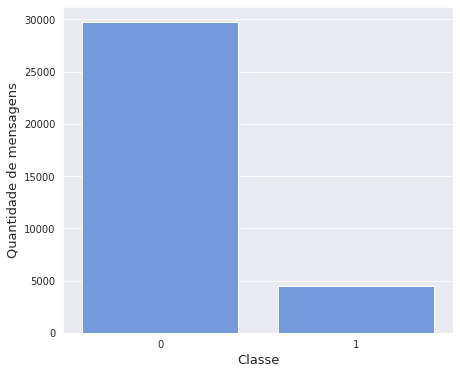

In [113]:
plt.figure(figsize=(7, 6))
sns.countplot(data=data_resampled, x='label', color='cornflowerblue')
plt.xlabel('Classe', fontsize=13)
plt.ylabel('Quantidade de mensagens', fontsize=13)
plt.savefig('Images/nova_distribuição_dados_nlpaug.png')

In [114]:
data_resampled['label'].value_counts()

0    29720
1     4484
Name: label, dtype: int64

In [115]:
data_resampled['cleaned_tweet'] = data_resampled['cleaned_tweet'].apply(str)

In [116]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(data_resampled['cleaned_tweet'])

data_resampled['cleaned_tweet'] = tokenizer.texts_to_sequences(data_resampled['cleaned_tweet'])
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

data_resampled['cleaned_tweet'] = pad_sequences(data_resampled['cleaned_tweet'], padding='post', maxlen=maxlen)

In [117]:
X_train, X_test, y_train, y_test = train_test_split(data_resampled['cleaned_tweet'],
                                                    data_resampled['label'],
                                                    test_size=0.2, 
                                                    random_state=23)

In [118]:
model = create_model(max_len)
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 100, 50)           1996400   
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 100, 64)           16064     
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 2,012,529
Trainable params: 2,012,529
Non-trainable params: 0
_________________________________________________________________


In [119]:
%%time
history = model.fit(X_train, y_train,
                    epochs=5,
                    validation_data=(X_test, y_test),
                    batch_size=10)

Epoch 1/5
2737/2737 [==============================] - 54s 19ms/step - loss: 0.2729 - accuracy: 0.9287 - val_loss: 0.2178 - val_accuracy: 0.9355
Epoch 2/5
2737/2737 [==============================] - 51s 19ms/step - loss: 0.1925 - accuracy: 0.9356 - val_loss: 0.2196 - val_accuracy: 0.9350
Epoch 3/5
2737/2737 [==============================] - 52s 19ms/step - loss: 0.1781 - accuracy: 0.9429 - val_loss: 0.2285 - val_accuracy: 0.9348
Epoch 4/5
2737/2737 [==============================] - 56s 20ms/step - loss: 0.1751 - accuracy: 0.9422 - val_loss: 0.2349 - val_accuracy: 0.9351
Epoch 5/5
2737/2737 [==============================] - 54s 20ms/step - loss: 0.1714 - accuracy: 0.9435 - val_loss: 0.2316 - val_accuracy: 0.9347
CPU times: user 6min 57s, sys: 19.7 s, total: 7min 17s
Wall time: 5min 22s


Training Accuracy: 0.9430
Testing Accuracy:  0.9347


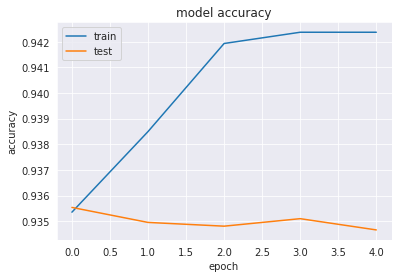

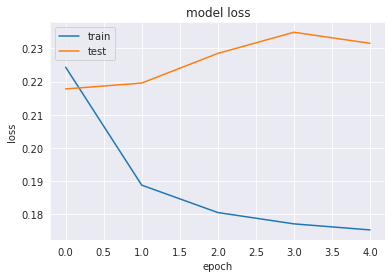

In [120]:
plot_model(model, data_augmentation='nlpaug')

In [121]:
submission(model, tokenizer, 'Submissions/submission_nlpaug.csv')

### EDA

In [125]:
data = pd.read_csv('Data/train.csv')
data = data.drop(columns=['id'])

In [126]:
data = data[data['label'] == 0]

f = open('eda.txt', 'r')

tweets = []
for x in f:
    _, tweet = x.split('\t')
    tweets.append(tweet.strip('\n'))
    
f.close()

negative_tweets = pd.DataFrame({
    'tweet': tweets,
    'label': 1
})

data_resampled = pd.concat([data, negative_tweets], axis=0)
data_resampled.head()
del data, negative_tweets

In [127]:
%%time
data_resampled['cleaned_tweet'] = data_resampled['tweet'].apply(lowercase)
data_resampled.head()

CPU times: user 31.4 ms, sys: 1.95 ms, total: 33.3 ms
Wall time: 34.2 ms


In [128]:
data_resampled.shape

(45414, 3)

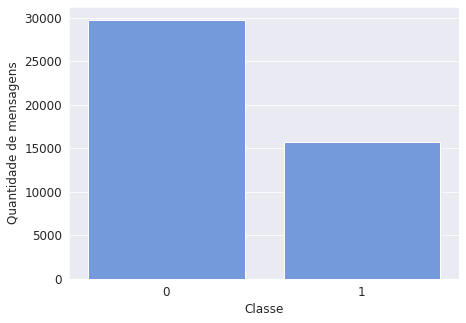

In [129]:
plt.figure(figsize=(7, 5))
sns.countplot(data=data_resampled, x='label', color='cornflowerblue')
plt.xlabel('Classe', fontsize=12)
plt.ylabel('Quantidade de mensagens', fontsize=12)
plt.tick_params(labelsize=12)
plt.savefig('Images/nova_distribuição_dados_eda.png')

In [130]:
data_resampled['label'].value_counts()

0    29720
1    15694
Name: label, dtype: int64

In [131]:
data_resampled['cleaned_tweet'] = data_resampled['cleaned_tweet'].apply(str)

In [132]:
X_train, X_test, y_train, y_test = train_test_split(data_resampled['cleaned_tweet'],
                                                    data_resampled['label'],
                                                    test_size=0.2,
                                                    random_state=23)

In [133]:
X_train, X_test, vocab_size, tokenizer = processing(X_train, X_test)

In [134]:
model = create_model(vocab_size)
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 100, 50)           2048850   
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 100, 64)           16064     
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 2,064,979
Trainable params: 2,064,979
Non-trainable params: 0
_________________________________________________________________


In [135]:
%%time
history = model.fit(X_train, y_train,
                    epochs=5,
                    validation_data=(X_test, y_test),
                    batch_size=10)

Epoch 1/5
3634/3634 [==============================] - 92s 25ms/step - loss: 0.2715 - accuracy: 0.8742 - val_loss: 0.0892 - val_accuracy: 0.9675
Epoch 2/5
3634/3634 [==============================] - 89s 25ms/step - loss: 0.0521 - accuracy: 0.9812 - val_loss: 0.0721 - val_accuracy: 0.9749
Epoch 3/5
3634/3634 [==============================] - 90s 25ms/step - loss: 0.0231 - accuracy: 0.9918 - val_loss: 0.0744 - val_accuracy: 0.9759
Epoch 4/5
3634/3634 [==============================] - 90s 25ms/step - loss: 0.0099 - accuracy: 0.9967 - val_loss: 0.0788 - val_accuracy: 0.9797
Epoch 5/5
3634/3634 [==============================] - 88s 24ms/step - loss: 0.0048 - accuracy: 0.9986 - val_loss: 0.0905 - val_accuracy: 0.9790
CPU times: user 11min 38s, sys: 40.9 s, total: 12min 19s
Wall time: 7min 29s


Training Accuracy: 0.9991
Testing Accuracy:  0.9790


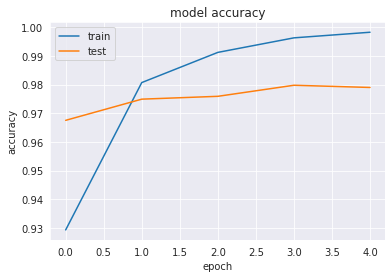

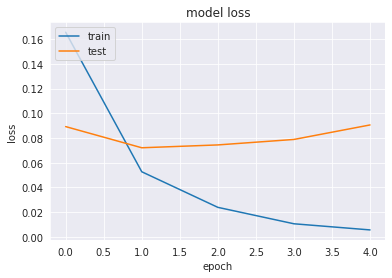

In [136]:
plot_model(model, data_augmentation='eda')

In [137]:
submission(model, tokenizer, 'Submissions/submission_eda.csv')

## Referências

https://realpython.com/python-keras-text-classification/

https://stackabuse.com/python-for-nlp-movie-sentiment-analysis-using-deep-learning-in-keras/

https://medium.com/saarthi-ai/sentence-classification-using-convolutional-neural-networks-ddad72c7048c

https://medium.com/analytics-vidhya/text-classification-from-bag-of-words-to-bert-1e628a2dd4c9

https://nlpforhackers.io/keras-intro/